In [451]:
import sys
import os
import itertools

sys.path.insert(0, 'D:\PhD\Code\PhDProject')

#TOOLS
from tools.load_tools import loadH5
from tools.processing_tools import multi_smooth, mean_norm
from tools.string_processing_tools import runLengthEncoding, NgramsInt, WindowRLEString, chunkDataRLE, lstStr2Str, lcsDist, dynamic_lcs_accumulated
from tools.plot_tools import plot_textcolorized

#SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import average_precision_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.metrics import confusion_matrix

#GOT
from GrammarofTime.SSTS.backend.gotstools import *

#PYTS
from pyts import datasets

#Wordcloud to show images of words
from wordcloud import WordCloud

#textdistance package
import textdistance

#other functions
from definitions import CONFIG_PATH

#pandas
from pandas import read_json

#novainstrumentation
from novainstrumentation import smooth

#ipython display
from IPython.display import display
# %matplotlib notebook
%matplotlib inline

# Intro

In this notebook, you will find the process of applying tools that are used for text classification and keyword extraction on a symbolic representation of time series. The process will mostly involve making time series classification from the UCR dataset repository. Several strategies will be employed. 

In this exercise, we will try to classify the GunPoint dataset into 2 different classes.

### Load data from UCR

Possible Datasets

['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'BME', 'Beef', 'BeetleFly', 'BirdChicken', 'CBF', 'Car', 'Chinatown', 'ChlorineConcentration', 'CinCECGtorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'ECG200', 'ECG5000', 'ECGFiveDays', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'Earthquakes', 'ElectricDevices', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MixedShapes', 'MixedShapesSmallTrain', 'MoteStrain', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'OSULeaf', 'OliveOil', 'PLAID', 'PhalangesOutlinesCorrect', 'Phoneme', 'PickupGestureWiimoteZ', 'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'Plane', 'PowerCons', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW', 'RefrigerationDevices', 'Rock', 'ScreenType', 'SemgHandGenderCh2', 'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'ShakeGestureWiimoteZ', 'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SmoothSubspace', 'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarlightCurves', 'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'TwoPatterns', 'UMD', 'UWaveGestureLibraryAll', 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'Wafer', 'Wine', 'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga']

In [457]:
data = datasets.fetch_ucr_dataset("GunPoint", use_cache=True, data_home=None, return_X_y=False)

X_train = data["data_train"]
y_train = data["target_train"]

X_test = data["data_test"]
y_test = data["target_test"]

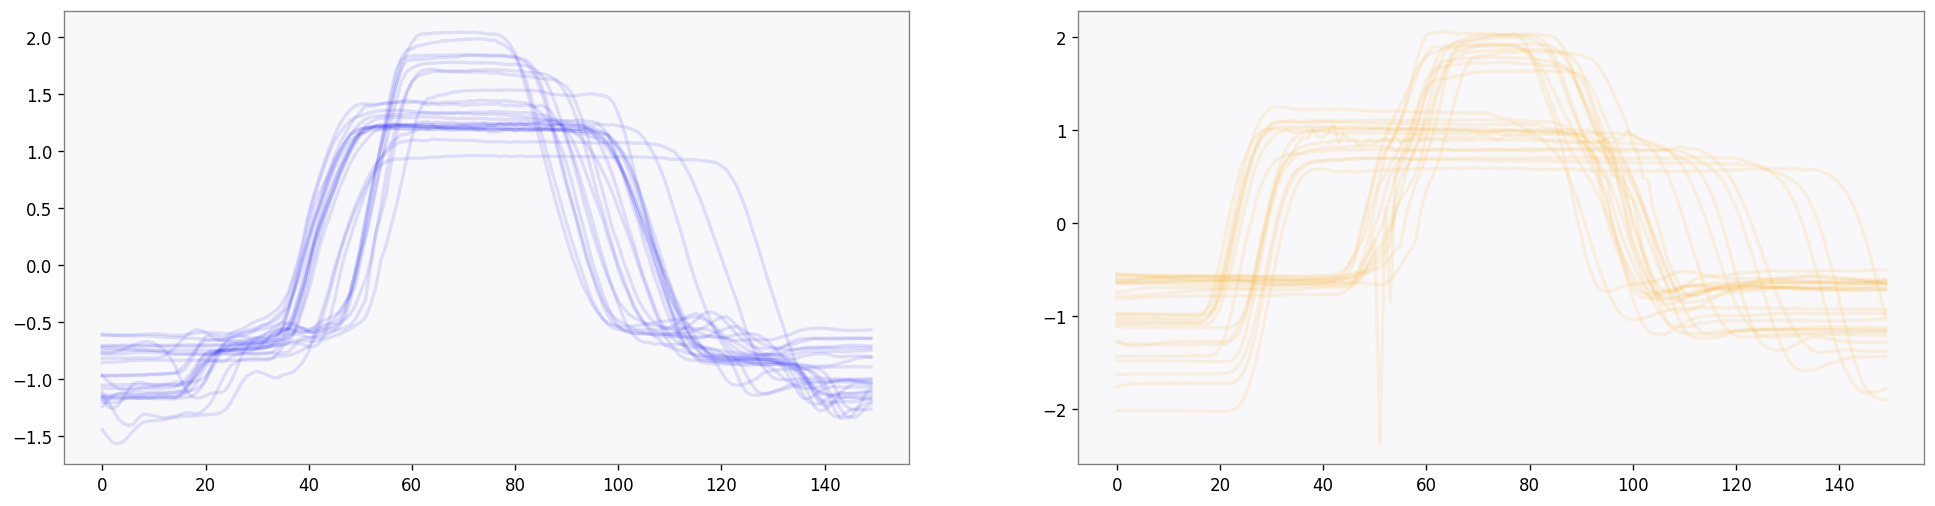

In [466]:
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.plot(np.transpose(X_train[np.where(y_train==1)[0]]), alpha=0.1, color='b')
ax2.plot(np.transpose(X_train[np.where(y_train==2)[0]]), alpha=0.1, color='orange')

### Transform TS to text documents

In order to apply text methods on time series analysis, we have to transform the time series into text. For that, we will apply SSTS, which is a library that converts time series into a specific set of chars, depending on the connotation methods used. This translation process has to describe the time series and provide a relevant and rich textual characterization of the signal. This characterization may depend on the types of characteristics we want to highlight and may be relevant to process the classification. 

As provided in [Notebook X](http://localhost:8888/notebooks/Term%20Frequency%20and%20Inverse%20Document%20Frequency.ipynb), one of the methods for document classification is the Bag of Words (BoW) or TFIDF matrix vectorizer. The process requires:

* ___documents___: represents the group of sentences or group of list of sentences inside the corpus. Each document is a sequence of words, separated by space. Each document is assigned to a label.
* ___corpus___: represents the group of documents and is used to create the vectorized matrix;
* ___words___: each sentence is a sequence of words. 

How do we translate this information into time series. What represent words, documents and a corpus? In this work, each time series is a document, while the words that build the document are translated windows of the time series into sequences of chars. The corpus will be the group of time series translated into documents. Therefore:

* ___corpus___ = ___set of time series___
* ___document___ = ___time series___
* ___words___ = ___window___

In [459]:
def sig2doc(sig, win_len, overlap_len, connotation_m):
    """
    sig: signal
    win_len: window size to create a word
    overlap_len: overlap of sliding window
    connotation_m: connotation method -> translation features
    """
    sig1_str = connotation([sig], connotation_m)[2]

    sig1_rle_str = chunkDataRLE(np.array(sig1_str), win_len, overlap_len)

    sig1_doc = lstStr2Str(sig1_rle_str)

    return sig1_doc

In [460]:
#Example 1
win = 1
overlap = 0
signal = X_train[0]
print("Class: ")
print(y_train[0])

#derivative connotation
sig_str1 = sig2doc(signal, win, overlap, "D1 0.075")

Class: 
2


z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z p p p p p p p p p p p p p p p p z z z z z z z z z z z z z z z z z z z z z z z n n n n n n n n n n z n n n n n n n z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z


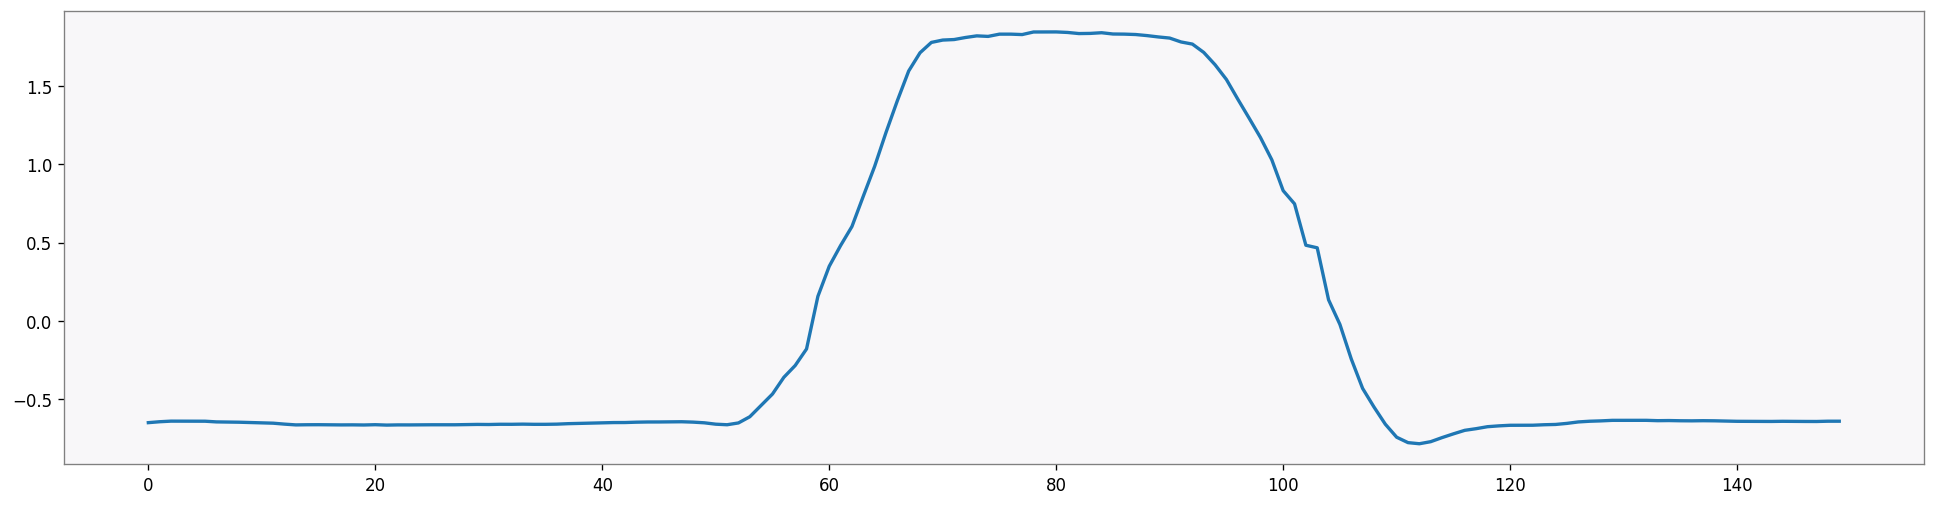

In [463]:
print(sig_str1)
plt.plot(signal)

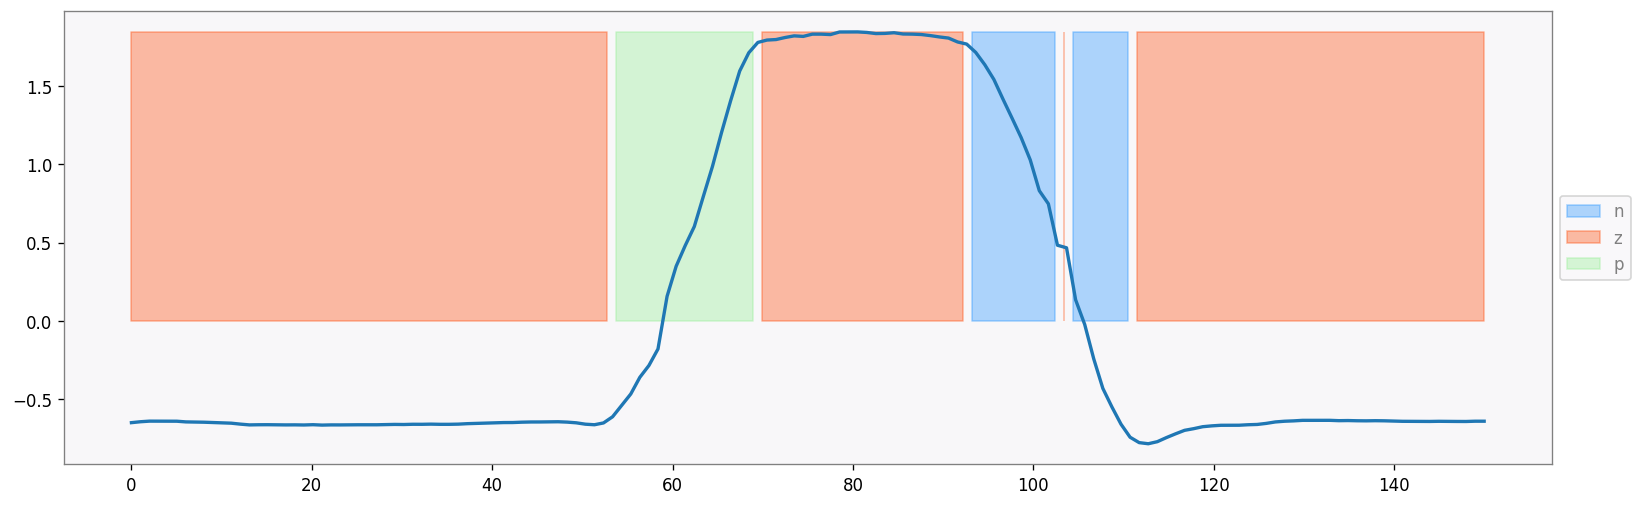

In [462]:
plot_textcolorized(signal, sig_str1.split(" "), plt.subplot(111))

In [455]:
#Example 2
win = 1
overlap = 0
signal = X_train[10]
print("Class: ")
print(y_train[10])
#derivative connotation
sig_str2 = sig2doc(signal, win, overlap, "D1 0.075")
print(sig_str2)

Class: 
6
n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n z z z z z z z p p p p p p p p p p p z z n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n z z p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p n n n n n n n n z z n n n n n n n n n p p p p p p p p p p p p p z p n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n p n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n n z z z z p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p p z p p p z p z


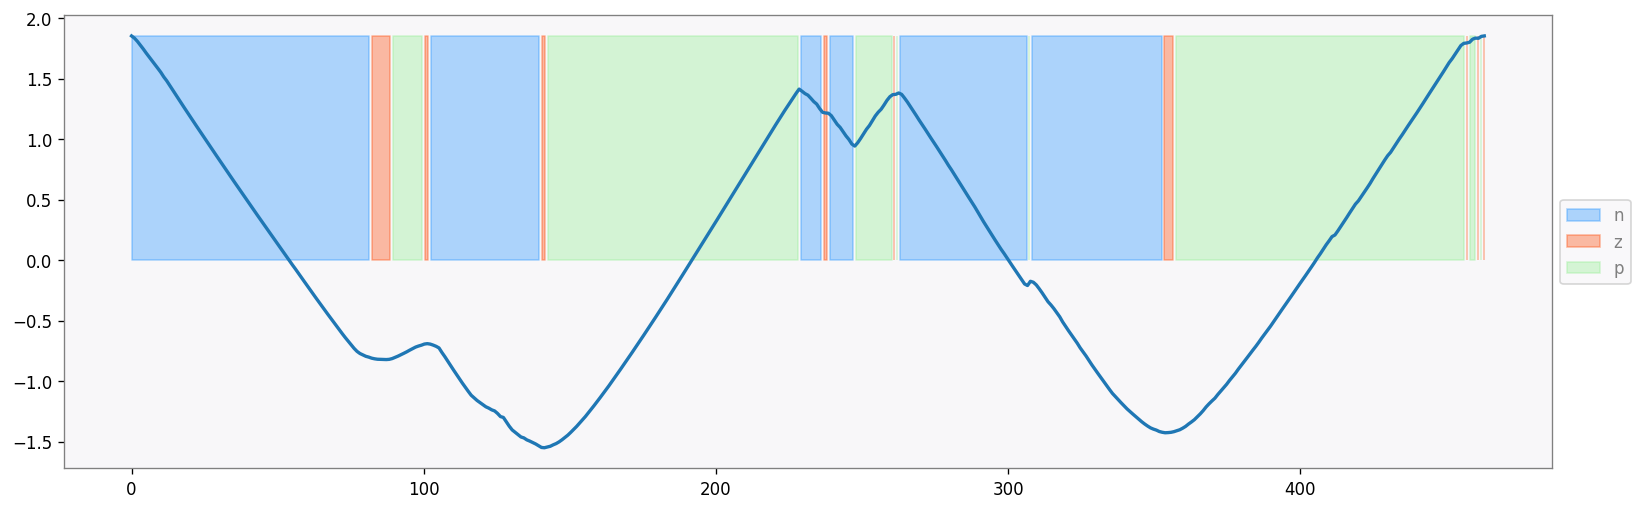

In [456]:
plot_textcolorized(signal, sig_str2.split(" "), plt.subplot(111))

In [22]:
import pandas as pd

#Create a Bag of Words model and TFIDF model
count_vec = CountVectorizer(ngram_range=(1,3), token_pattern=r"(?u)\b\w+\b")
ex_1_bow = count_vec.fit_transform([sig_str1, sig_str2])
ex_1_df = pd.DataFrame(ex_1_bow.toarray(), columns= count_vec.get_feature_names())


In [23]:
#Create a Bag of Words model and TFIDF model
count_vec = CountVectorizer(ngram_range=(1,3), token_pattern=r"(?u)\b\w+\b")
ex_1_bow = count_vec.fit_transform([sig_str1, sig_str2])
ex_1_df = pd.DataFrame(ex_1_bow.toarray(), columns= count_vec.get_feature_names())
display(ex_1_df)

,n,n n,n n n,n n nz,n n z,n n zn,n nz,n nz z,n z,n z z,...,z z z,z z zp,z zp,z zp p,zn,zn n,zn n n,zp,zp p,zp p p
0,8,6,4,0,1,1,0,0,1,1,...,50,1,1,1,1,1,1,1,1,1
1,12,9,7,1,1,0,1,1,2,2,...,37,1,1,1,0,0,0,1,1,1


In [24]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), token_pattern=r"(?u)\b\w+\b", smooth_idf=True)
ex_2_tfidf = tfidf_vec.fit_transform([sig_str1, sig_str2])
ex_2_df = pd.DataFrame(ex_2_tfidf.toarray(), columns= tfidf_vec.get_feature_names())
display(ex_2_df)

,n,n n,n n n,n n nz,n n z,n n zn,n nz,n nz z,n z,n z z,...,z z z,z z zp,z zp,z zp p,zn,zn n,zn n n,zp,zp p,zp p p
0,0.085765,0.064324,0.042882,0.000000,0.010721,0.015067,0.000000,0.000000,0.010721,0.010721,...,0.536030,0.010721,0.010721,0.010721,0.015067,0.015067,0.015067,0.010721,0.010721,0.010721
1,0.155104,0.116328,0.090477,0.018166,0.012925,0.000000,0.018166,0.018166,0.025851,0.025851,...,0.478237,0.012925,0.012925,0.012925,0.000000,0.000000,0.000000,0.012925,0.012925,0.012925


Class: 
2
z z z z z z z z z z z z z z z z z z z z z z p p p p p p p p pz z z z z z z z z z z z z z z n n n n n n n n n nz z z z z z z z z z z z z z z z z z z z


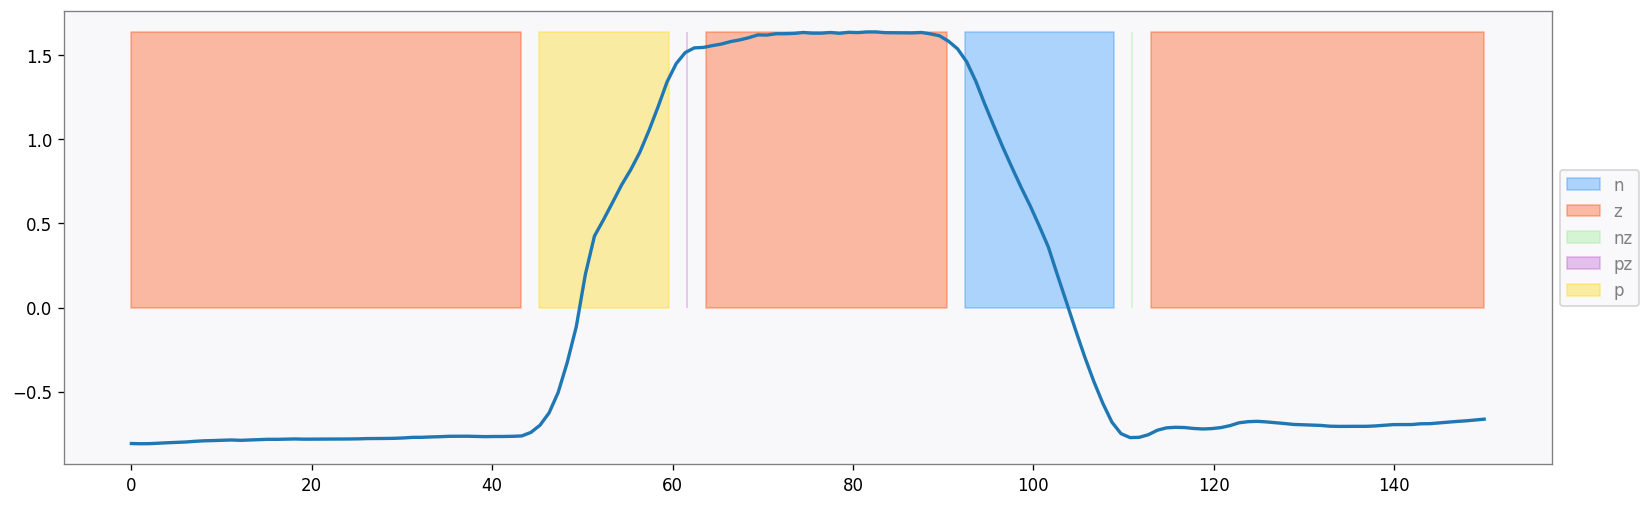

In [25]:
#Compute distance between vectors from other example
win = 2
overlap = 0
signal = X_train[16]
print("Class: ")
print(y_train[16])
#derivative connotation
sig_str3 = sig2doc(signal, win, overlap, "D1 0.075")
print(sig_str3)
plot_textcolorized(signal, sig_str3.split(" "), plt.subplot(111))

In [26]:
#count vectorizer dist
query_cvec = count_vec.transform([sig_str3])
cosine_similarity(query_cvec, ex_1_bow).flatten()

array([0.99751005, 0.99189064])

In [27]:
#tfidf vectorizer dist
query_tfidf = tfidf_vec.transform([sig_str3])
cosine_similarity(query_tfidf, ex_2_tfidf).flatten()

array([0.99665951, 0.99172011])

___Results___:As you can see, the derivative is not enough to differentiate these two signals very well...although, using a different time window might be sufficient. In addition, adding more connotation methods can be enough to enhance the difference.

In [28]:
win = 2
overlap=0
#derivative connotation
sig_str1 = sig2doc(X_train[1], win, overlap, "AQ 4 D1 0.1")
sig_str2 = sig2doc(X_train[10], win, overlap, "AQ 4 D1 0.1")
sig_str3 = sig2doc(X_train[25], win, overlap, "AQ 4 D1 0.1")

print(y_train[25])
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), stop_words=["dz"], token_pattern=r"(?u)\b\w+\b", smooth_idf=True)
ex_2_tfidf = tfidf_vec.fit_transform([sig_str1, sig_str2])
ex_2_df = pd.DataFrame(ex_2_tfidf.toarray(), columns= tfidf_vec.get_feature_names())
display(ex_2_df)

#tfidf vectorizer dist
query_tfidf = tfidf_vec.transform([sig_str3])
display(cosine_similarity(query_tfidf, ex_2_tfidf).flatten())

2


,an,an anaz,an anaz az,anaz,anaz az,anaz az az,az,az az,az az az,az az azbz,...,dp dpdz,dp dpdz dzdn,dpdz,dpdz dn,dpdz dn cn,dpdz dzdn,dpdz dzdn dn,dzdn,dzdn dn,dzdn dn dn
0,0.000000,0.000000,0.000000,0.024898,0.024898,0.024898,0.448164,0.373470,0.323674,0.000000,...,0.034993,0.034993,0.024898,0.000000,0.000000,0.034993,0.034993,0.034993,0.034993,0.034993
1,0.040641,0.040641,0.040641,0.028916,0.028916,0.028916,0.433747,0.346998,0.289165,0.040641,...,0.000000,0.000000,0.028916,0.040641,0.040641,0.000000,0.000000,0.000000,0.000000,0.000000


array([0.90572502, 0.89521532])

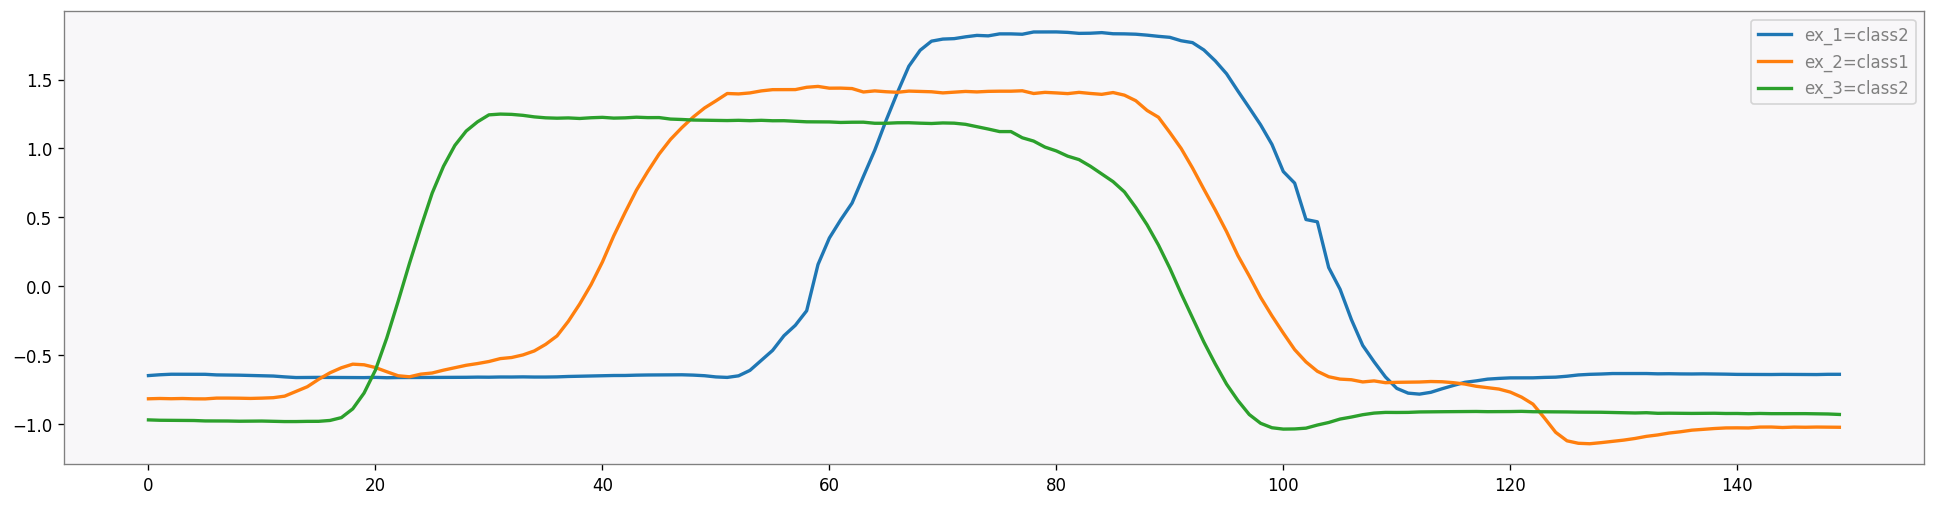

In [29]:
plt.plot(X_train[0], label="ex_1=class2")
plt.plot(X_train[10], label="ex_2=class1")
plt.plot(X_train[25], label="ex_3=class2")
plt.legend()

In [30]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), stop_words=["dz"], token_pattern=r"(?u)\b\w+\b", smooth_idf=True)
ex_2_tfidf = tfidf_vec.fit_transform([sig_str1, sig_str2, sig_str3])
ex_2_df = pd.DataFrame(ex_2_tfidf.toarray(), columns= tfidf_vec.get_feature_names())
display(ex_2_df)

,an,an anaz,an anaz az,anaz,anaz az,anaz az az,az,az az,az az az,az az azap,...,dpdz dn,dpdz dn cn,dpdz dzdn,dpdz dzdn dn,dzcz,dzcz cz,dzcz cz cz,dzdn,dzdn dn,dzdn dn dn
0,0.000000,0.000000,0.000000,0.031310,0.031310,0.031310,0.437666,0.364722,0.316092,0.000000,...,0.000000,0.000000,0.041169,0.041169,0.000000,0.000000,0.000000,0.041169,0.041169,0.041169
1,0.048025,0.048025,0.048025,0.036525,0.036525,0.036525,0.425468,0.340375,0.283646,0.000000,...,0.048025,0.048025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.403053,0.322442,0.241832,0.045495,...,0.000000,0.000000,0.000000,0.000000,0.045495,0.045495,0.045495,0.000000,0.000000,0.000000


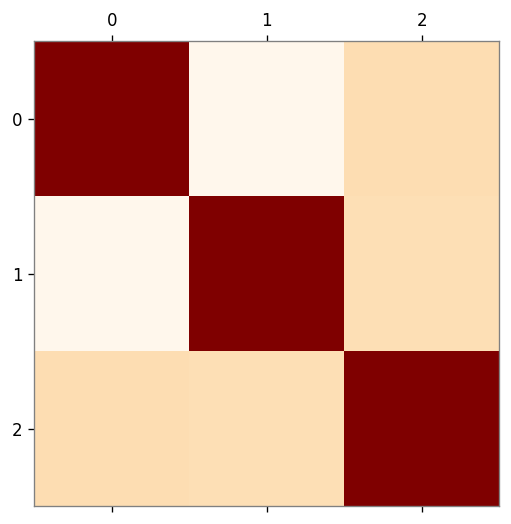

In [31]:
plt.matshow(cosine_similarity(ex_2_tfidf.toarray(), ex_2_tfidf.toarray()), cmap="OrRd")

## Classification of entire dataset based on testing - Derivative

In [32]:
#Convert all signals to documents
doc_train = []
doc_test = []
win = 1
overlap = 0
for s, (sig_i, label) in enumerate(zip(X_train, y_train)):
    doc_train.append(sig2doc(sig_i, win, overlap, "D1 0.075"))

for s, (sig_i, label) in enumerate(zip(X_test, y_test)):
    doc_test.append(sig2doc(sig_i, win, overlap, "D1 0.075"))

In [33]:
#Compute the TFIDF vector of the training dataset
vectorizer = TfidfVectorizer(ngram_range=(1,3), token_pattern=r"(?u)\b\w+\b")
tfidf_model = vectorizer.fit_transform(doc_train)

In [34]:
#Search for prediction of testing set as queries
preds = []
preds2 = []
for ind, i in enumerate(doc_test):
    closest_seq = []
    class_seq = []
    query_transform = vectorizer.transform([i])
    dist = cosine_similarity(query_transform, tfidf_model).flatten()
    preds2.append(y_train[np.argmax(dist)])
    
#     for class_i in np.unique(y_train):
#         class_seq.append(class_i)
#         closest_seq.append(np.mean(dist[np.where(y_train==class_i)]))
        

#     preds.append(class_seq[np.argmax(closest_seq)])

In [35]:
#Compyte confusion matrix
a = classification_report(y_test, preds2)
print(a)

              precision    recall  f1-score   support

           1       0.90      0.84      0.87        76
           2       0.85      0.91      0.88        74

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



## Classification of entire dataset based on Countvectorizer - derivative

In [36]:
#Compute the Count vector of the training dataset
vectorizer = CountVectorizer(ngram_range=(1,3), token_pattern=r"(?u)\b\w+\b")
count_model = vectorizer.fit_transform(doc_train)

In [37]:
#Search for prediction of testing set as queries
preds = []
preds2 = []
for ind, i in enumerate(doc_test):
    closest_seq = []
    class_seq = []
    query_transform = vectorizer.transform([i])
    dist = cosine_similarity(query_transform, count_model).flatten()
    preds2.append(y_train[np.argmax(dist)])

#Compyte confusion matrix
a = classification_report(y_test, preds2)
print(a)

              precision    recall  f1-score   support

           1       0.89      0.84      0.86        76
           2       0.85      0.89      0.87        74

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



## Classification of entire dataset based on testing - Amplitude

In [38]:
#Convert all signals to documents
doc_train = []
doc_test = []
win = 1
overlap = 0
for s, (sig_i, label) in enumerate(zip(X_train, y_train)):
    doc_train.append(sig2doc(sig_i, win, overlap, "AQ 4"))

for s, (sig_i, label) in enumerate(zip(X_test, y_test)):
    doc_test.append(sig2doc(sig_i, win, overlap, "AQ 4"))

#Compute the TFIDF vector of the training dataset
vectorizer = TfidfVectorizer(ngram_range=(1,3), token_pattern=r"(?u)\b\w+\b")
tfidf_model = vectorizer.fit_transform(doc_train)

#Search for prediction of testing set as queries
preds2 = []
for ind, i in enumerate(doc_test):
    closest_seq = []
    class_seq = []
    query_transform = vectorizer.transform([i])
    dist = euclidean_distances(query_transform, tfidf_model).flatten()
    preds2.append(y_train[np.argmin(dist)])

#     for class_i in np.unique(y_train):
#         class_seq.append(class_i)
#         closest_seq.append(np.mean(dist[np.where(y_train==class_i)]))

#     preds.append(class_seq[np.argmax(closest_seq)])

#Compute confusion matrix
a = classification_report(y_test, preds2)
print(a)

              precision    recall  f1-score   support

           1       0.82      0.96      0.88        76
           2       0.95      0.78      0.86        74

    accuracy                           0.87       150
   macro avg       0.89      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



In [39]:
#How to add more information on the vectorized matrix?
#Next steps:
# - try to have a single_char sequence and long_word sequence
# - try multiple connotations
# How to add this?
# - soma das distâncias entre os vectores de cada abordagem
# - adicionar frequencias 

## Usage of multiple connotation methods for the classification

### Use multiple connotations in the same word

In [93]:
#Convert all signals to documents
doc_train = []
doc_test = []
win = 1
overlap = 0
for s, (sig_i, label) in enumerate(zip(X_train, y_train)):
    doc_train.append(sig2doc(sig_i, win, overlap, "AQ 3 D1 0.025"))

for s, (sig_i, label) in enumerate(zip(X_test, y_test)):
    doc_test.append(sig2doc(sig_i, win, overlap, "AQ 3 D1 0.025"))

In [141]:
#Compute the TFIDF vector of the training dataset
vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words=["cz"], token_pattern=r"(?u)\b\w+\b")
tfidf_model = vectorizer.fit_transform(doc_train)

In [142]:
#Search for prediction of testing set as queries
preds = []
preds2 = []
for ind, i in enumerate(doc_test):
    closest_seq = []
    class_seq = []
    query_transform = vectorizer.transform([i])
    dist = cosine_similarity(query_transform, tfidf_model).flatten()
    preds2.append(y_train[np.argmax(dist)])

#Compyte confusion matrix
a = classification_report(y_test, preds2)
print(a)

              precision    recall  f1-score   support

           1       1.00      0.96      0.98        76
           2       0.96      1.00      0.98        74

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



### Use multiple connotations but in different vectorizers

In [92]:
#Convert all signals to documents
doc_train_dif = []
doc_test_dif = []

doc_train_amp = []
doc_test_amp = []

win = 1
overlap = 0
for s, (sig_i, label) in enumerate(zip(X_train, y_train)):
    doc_train_dif.append(sig2doc(sig_i, win, overlap, "D1 0.025"))
    doc_train_amp.append(sig2doc(sig_i, win, overlap, "AQ 4"))

for s, (sig_i, label) in enumerate(zip(X_test, y_test)):
    doc_test_dif.append(sig2doc(sig_i, win, overlap, "D1 0.025"))
    doc_test_amp.append(sig2doc(sig_i, win, overlap, "AQ 4"))

#Compute the TFIDF vector of the training dataset
vectorizer_dif = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b", min_df=0.3, max_df=0.9)
tfidf_model_dif = vectorizer_dif.fit_transform(doc_train_dif)
vectorizer_amp = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b", min_df=0.3, max_df=0.9)
tfidf_model_amp = vectorizer_amp.fit_transform(doc_train_amp)

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [44]:
#Search for prediction of testing set as queries
preds = []
preds2 = []
for ind, (i_dif, (i_amp, i_amp2)) in enumerate(zip(doc_test_dif, zip(doc_test_amp, doc_test_amp2))):
    closest_seq = []
    class_seq = []
    
    query_amp_transform = vectorizer_amp.transform([i_amp])
    query_dif_transform = vectorizer_dif.transform([i_dif])
    
    dist_dif = cosine_similarity(query_dif_transform, tfidf_model_dif).flatten()
    dist_amp = cosine_similarity(query_amp_transform, tfidf_model_amp).flatten()

    dist = dist_dif + dist_amp
    
    preds2.append(y_train[np.argmax(dist)])

#Compyte confusion matrix
a = classification_report(y_test, preds2)
print(a)

NameError: name 'doc_test_amp2' is not defined

## Analysis of CounterVectorize and TFIDF histograms

In [46]:
data = datasets.fetch_ucr_dataset("GunPoint", use_cache=True, data_home=None, return_X_y=False)

X_train = data["data_train"]
y_train = data["target_train"]

X_test = data["data_test"]
y_test = data["target_test"]

#class 1
X_1 = X_train[np.where(y_train==1)[0]]
X_2 = X_train[np.where(y_train==2)[0]]

In [90]:
#Convert all signals to documents
doc_1 = []
doc_2 = []

win = 1
overlap = 0
for s, sig_i in enumerate(X_1):
    doc_1.append(sig2doc(sig_i, win, overlap, "AQ 3 D1 0.075"))

for s, sig_i in enumerate(X_2):
    doc_2.append(sig2doc(sig_i, win, overlap, "AQ 3 D1 0.075"))
    
#Compute the TFIDF vector of the training dataset
vectorizer_1 = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b", min_df=0.1, max_df=0.9)
count_model_1 = vectorizer_1.fit_transform(doc_1)
vectorizer_2 = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b", min_df=0.1, max_df=0.9)
count_model_2 = vectorizer_2.fit_transform(doc_2)

0    63.917029
1    69.813479
dtype: float64


,0,1,dif
an,0.114847,0.033040,1.106348
an an,0.100197,0.037559,0.909397
an az,0.029785,0.010098,0.987206
ap,0.119649,0.041012,0.978917
ap ap,0.092381,0.035685,0.885413
ap az,0.023789,NaN,NaN
ap bp,0.021309,0.008869,0.824402
ap bz,0.011766,NaN,NaN
az an,0.022042,NaN,NaN
az ap,0.036824,0.009531,1.177582


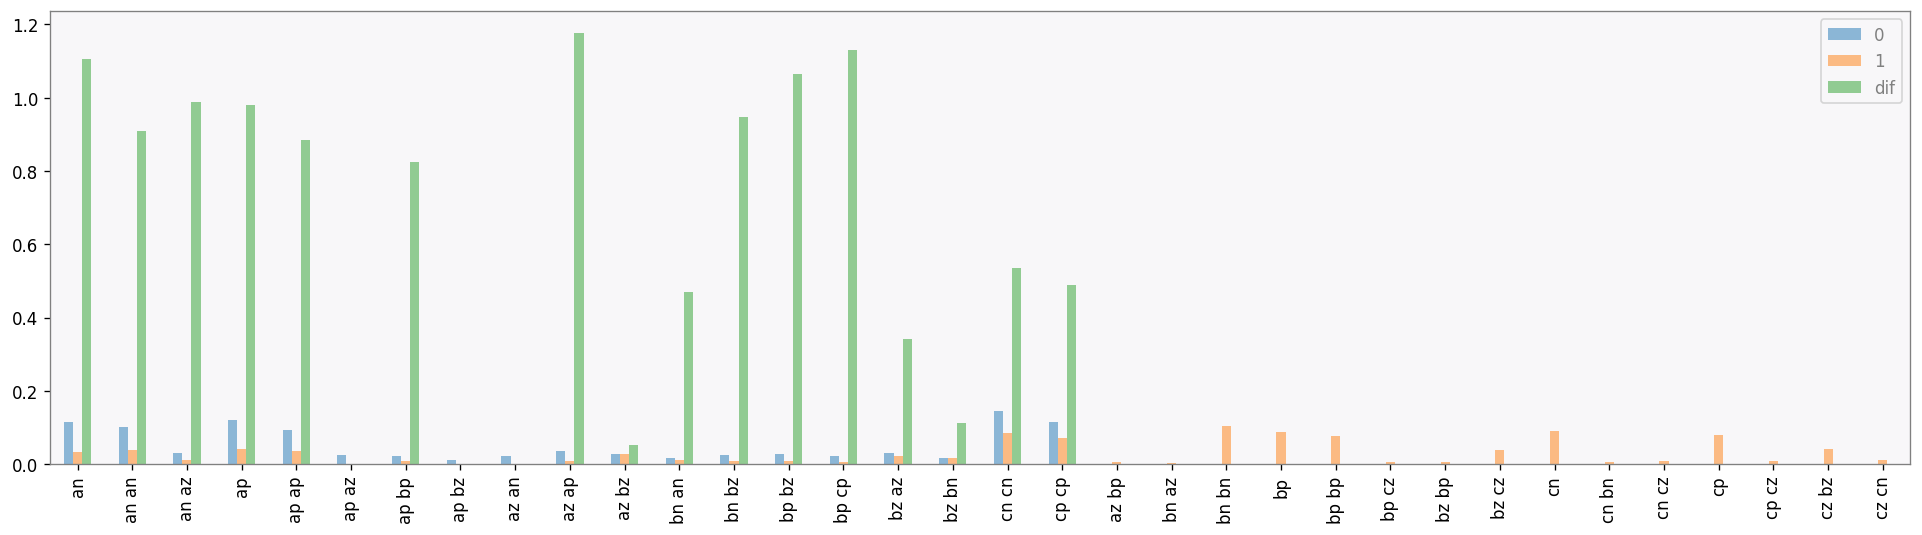

In [91]:
hist_1_df = pd.DataFrame(count_model_1.toarray(), columns= vectorizer_1.get_feature_names())
hist_2_df = pd.DataFrame(count_model_2.toarray(), columns= vectorizer_2.get_feature_names())

hist_1 = hist_1_df.sum(axis=0)
hist_2 = hist_2_df.sum(axis=0)

hist_final = pd.concat([hist_1, hist_2], axis=1)

print(hist_final.sum(axis=0))

hist_final = hist_final/hist_final.sum(axis=0)
hist_final["dif"] = np.abs(2*(hist_final[0]-hist_final[1]))/(hist_final[0]+hist_final[1])

ax = hist_final.plot.bar(alpha=0.5)

ax.set_xticks(range(len(hist_final.index)))
ax.set_xticklabels(hist_final.index)

display(hist_final)
# hist_1_df.sum(axis=0).plot.hist(bins=25, alpha=0.4)
# hist_2_df.sum(axis=0).plot.hist(bins=25, alpha=0.4)

From the histogram presented, we can see some differences between the two main groups of signals. Group of class 1 (blue) has several visual characteristics that can be highlighted in relation to group of class 2 (orange). This is an example of class 1 and class 2 time series:

[[<matplotlib.lines.Line2D at 0x239cf8faac0>],

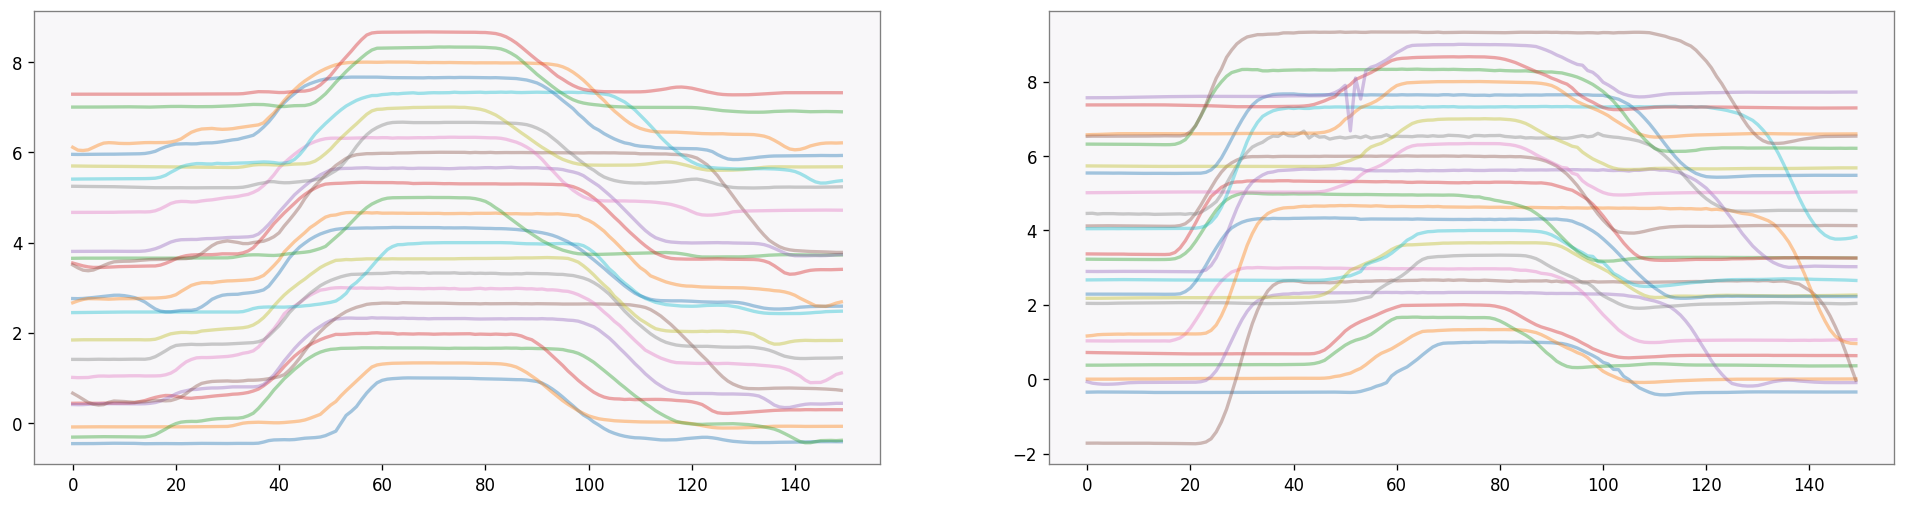

In [84]:
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

[ax1.plot(mean_norm(X_1[i]) + i/3, alpha=0.4) for i in range(len(X_1))]
[ax2.plot(mean_norm(X_2[i]) + i/3, alpha=0.4) for i in range(len(X_2))]


1 - Typically, class 1 has one "peaks" or slight elevation before and after the pateau, while class 2 has only the plateau. Therefore, it would be expected to find rising and falling characters in the lower amplitudes of the signal, in contrast to group class 2, which would have less of these.

2 - The zero derivative would therefore be also higher for class 2, which has less variations.

The histogram shows the distributions of characters with a 2-gram, based on the translation of the signal. Are we able to differenciate between these two classes? Where are the differences between the two distributions?

a - Positive differences are higher presence of the word in class 1
b - Negative differences are higher presence of the word in class 2

As expected, class 1 has more words related with low amplitude rising as well as rising -> zero derivative:

- word _ap_: low amplitude and rising
- word _ap az_: low amplitude, rising and zero derivative
- word _az ap_: low amplitude, zero and rising
- word _ap an_: low peak at low amplitude
- word _bz bp_: medium amplitude zero and rising

On the higher amplitude level, nothing is much different in both. 

Let us print the 10 more frequent words for each class:

In [87]:
sorted_values1 = hist_1.sort_values()[::-1][:20]
sorted_values2 = hist_2.sort_values()[::-1][:20]
sorted_values_dif = hist_final["dif"].sort_values()[::-1][:20]

print(sorted_values1)
print(sorted_values2)
print(sorted_values_dif)

az       10.536162
cz        9.860994
az az     9.618325
cz cz     9.577783
bz        6.445018
bz bz     5.643780
bn        3.443034
bp        3.126361
bn bn     3.074097
bp bp     2.741153
cn        1.976916
cn cn     1.861272
cp        1.484651
cp cp     1.472603
ap        1.332746
an        1.261933
an an     1.092360
ap ap     1.028146
az ap     0.410402
bz az     0.346521
dtype: float64
az       11.097817
az az    10.393481
cz        9.369865
bz        8.764665
cz cz     8.535158
bz bz     7.550034
cn cn     2.615421
cn        2.602804
cp        2.419426
bn        2.247576
bn bn     2.151239
cp cp     2.141468
bp        1.892016
bp bp     1.607230
an an     0.957138
ap ap     0.928956
bz cz     0.890587
cz bz     0.879874
ap        0.879399
an        0.831072
dtype: float64
cz bp         NaN
cz bn         NaN
cp cn         NaN
cn cz         NaN
cn bz         NaN
cn bp         NaN
cn ap         NaN
bz cn         NaN
bp cn         NaN
ap cz         NaN
ap cn         NaN
ap az    1.5

### Let us try on other datasets to see if it has any chance of successfully classifying the time series
['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'BME', 'Beef', 'BeetleFly', 'BirdChicken', 'CBF', 'Car', 'Chinatown', 'ChlorineConcentration', 'CinCECGtorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'ECG200', 'ECG5000', 'ECGFiveDays', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'Earthquakes', 'ElectricDevices', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MixedShapes', 'MixedShapesSmallTrain', 'MoteStrain', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'OSULeaf', 'OliveOil', 'PLAID', 'PhalangesOutlinesCorrect', 'Phoneme', 'PickupGestureWiimoteZ', 'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'Plane', 'PowerCons', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW', 'RefrigerationDevices', 'Rock', 'ScreenType', 'SemgHandGenderCh2', 'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'ShakeGestureWiimoteZ', 'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SmoothSubspace', 'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarlightCurves', 'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'TwoPatterns', 'UMD', 'UWaveGestureLibraryAll', 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'Wafer', 'Wine', 'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga']

In [491]:
data = datasets.fetch_ucr_dataset("Trace", use_cache=True, data_home=None, return_X_y=False)

X_train = data["data_train"]
y_train = data["target_train"]

X_test = data["data_test"]
y_test = data["target_test"]

#class 1
X_1 = X_train[np.where(y_train==1)[0]]
X_2 = X_train[np.where(y_train==2)[0]]

#Convert all signals to documents
doc_train = []
doc_test = []
win = 1
overlap = 0
sm_factor = 25
for s, (sig_i, label) in enumerate(zip(X_train, y_train)):
    sig_i = smooth(sig_i, sm_factor)
    doc_train.append(sig2doc(sig_i, win, overlap, "AQ 4 D1 0.025"))

for s, (sig_i, label) in enumerate(zip(X_test, y_test)):
    sig_i = smooth(sig_i, sm_factor)
    doc_test.append(sig2doc(sig_i, win, overlap, "AQ 4 D1 0.025"))
    
#Compute the TFIDF vector of the training dataset
vectorizer = TfidfVectorizer(ngram_range=(1,3), token_pattern=r"(?u)\b\w+\b")
tfidf_model = vectorizer.fit_transform(doc_train)

#Search for prediction of testing set as queries
preds = []
preds2 = []
for ind, i in enumerate(doc_test):
    closest_seq = []
    class_seq = []
    query_transform = vectorizer.transform([i])
    dist = cosine_similarity(query_transform, tfidf_model).flatten()
    preds2.append(y_train[np.argmax(dist)])

#Compyte confusion matrix
a = classification_report(y_test, preds2)
print(a)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        19

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



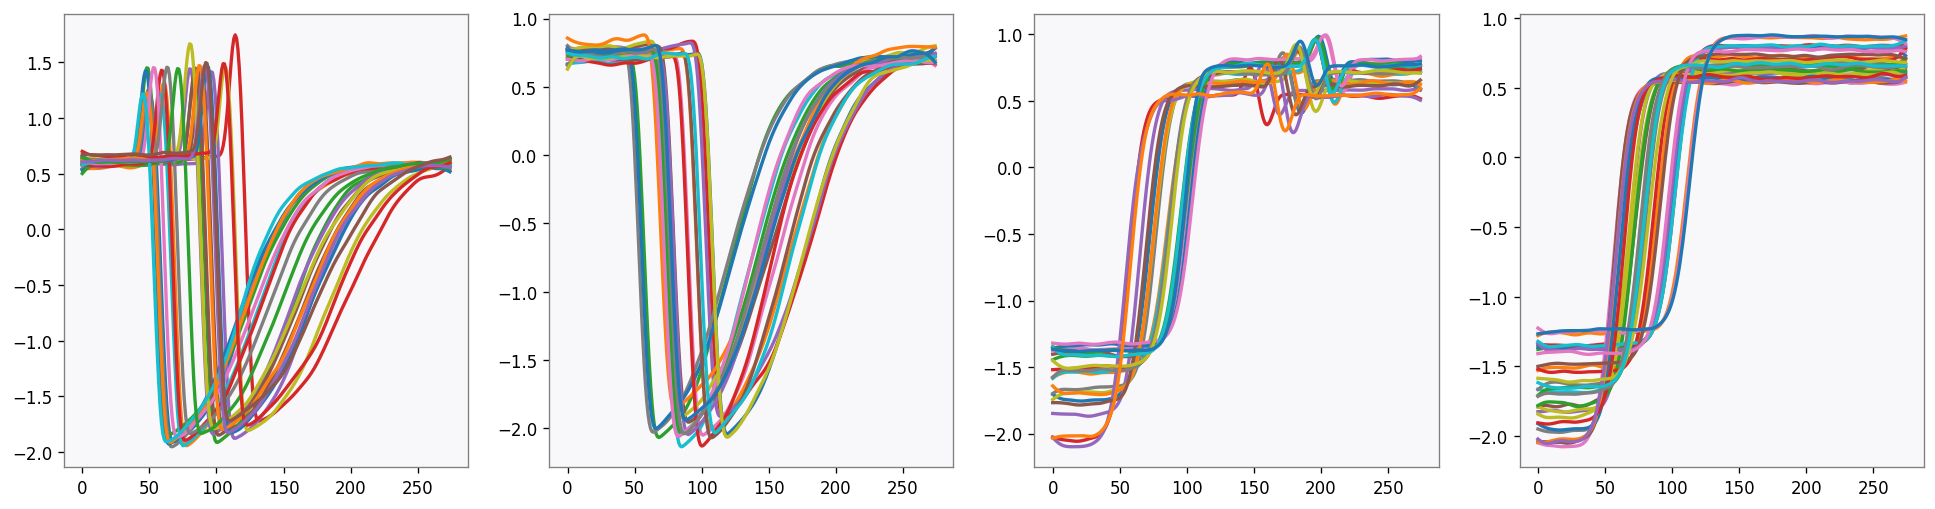

In [492]:
fig, axs = plt.subplots(1, len(np.unique(y_train)))

for ax, label in zip(axs, np.unique(y_train)):
    ax.plot(np.transpose(multi_smooth(X_train[np.where(y_train==label)[0]], sm_factor)))


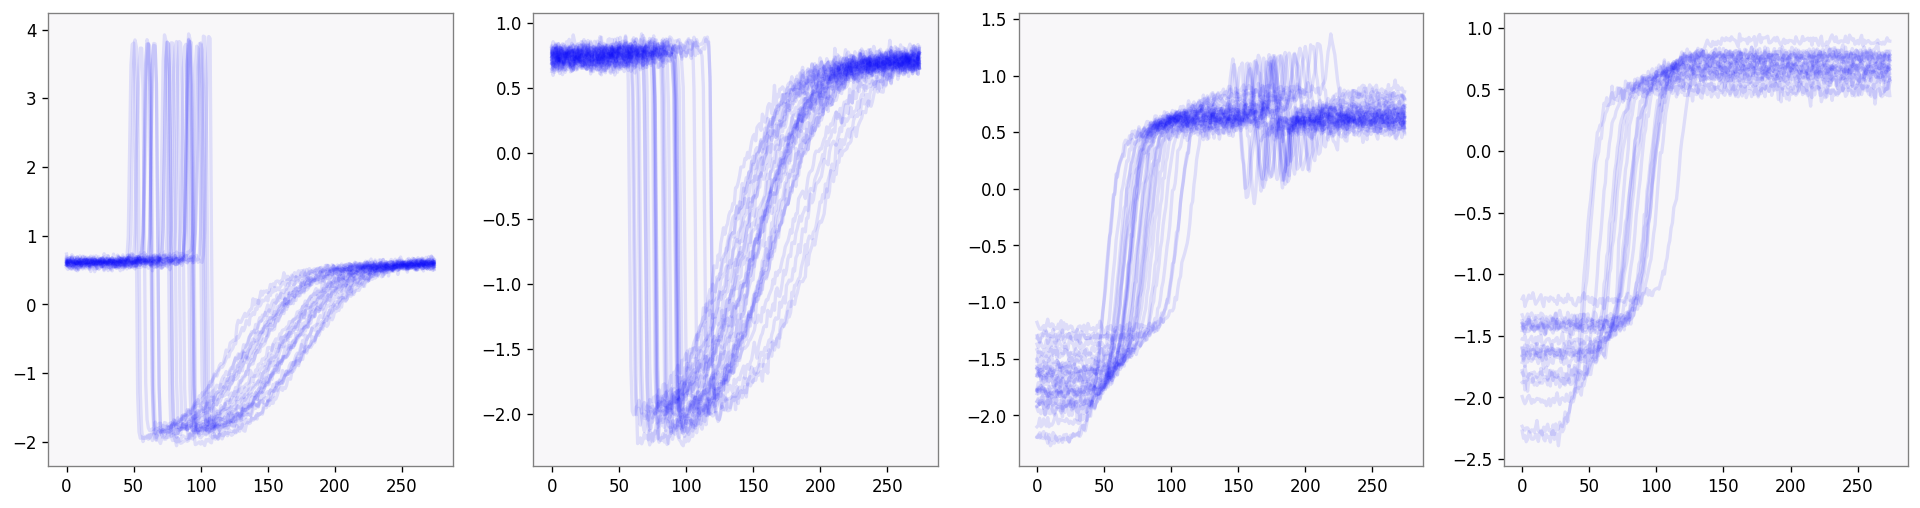

In [494]:
fig, axs = plt.subplots(1, len(np.unique(y_train)))

for ax, label in zip(axs, np.unique(y_train)):
    ax.plot(np.transpose(X_test[np.where(preds2==label)[0]]), alpha=0.1, color="b")


### Notas por dataset:

- ACSF1: ter uma medida de amplitude absoluta seria capaz de ser melhor para diferenciar séries temporais com ampltiudes diferentes

- CBF really needs the filter

- UMD: it is able to easily differentiate the time series based on the derivative and ampltiude char

- Trace: it is able to easily separate the traces based on AQ+Dif but with filtering (100% when using Dif=0.075)